# Terrain Shadows: The Bilbao Valley

Most thermal comfort studies take place on flat or gently sloping urban terrain.
Bilbao is different: the city sits in a narrow river valley (the Nervión), flanked by
hills that rise 200–400 m above the valley floor within just a few kilometres.

This creates a shadow geometry that standard flat-city models miss entirely —
hillsides block the early-morning sun from the valley floor in summer, while east- and
west-facing slopes receive sharply asymmetric radiation all day.

This tutorial demonstrates:

- Loading a **normalised DSM** (building heights above ground) with a separate DEM using `dsm_relative=True`
- Why **`max_shadow_distance_m`** matters in hilly terrain — and how to choose it
- How terrain shadows create **asymmetric sun exposure** across a valley
- Visualising a terrain profile to understand the geometry

**Data sources:**

- BDSM/CDSM/DEM: Derived from [PNOA-LiDAR](https://pnoa.ign.es/pnoa-lidar) point cloud data.
  Instituto Geográfico Nacional (IGN), Spain. Licence: CC BY 4.0.
- EPW weather: [EnergyPlus Weather Data](https://energyplus.net/weather), U.S. Department of Energy.


In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import solweig

DATA_DIR = Path("demos/data/bilbao")
WORK_DIR = Path("temp/tutorial_cache/bilbao")
WORK_DIR.mkdir(parents=True, exist_ok=True)

assert (DATA_DIR / "BDSM.tif").exists(), f"Demo data not found at {DATA_DIR.resolve()}"

# 3 km × 3 km extract: Casco Viejo, Nervión riverfront, and flanking hillsides
# EPSG:25830 (ETRS89 / UTM zone 30N)
EXTENTS_BBOX = [499600, 4794000, 502600, 4797000]

## 1. Inspect the terrain

Before running any calculation, let's understand the landscape.
The DEM contains terrain elevation; the BDSM contains _building heights above ground_ (normalised DSM).
Together they describe the full height geometry of the scene.


DEM  shape: (680, 680)  range: -2 – 103 m
BDSM shape: (1359, 1359)  building heights: 0 – 52 m above ground


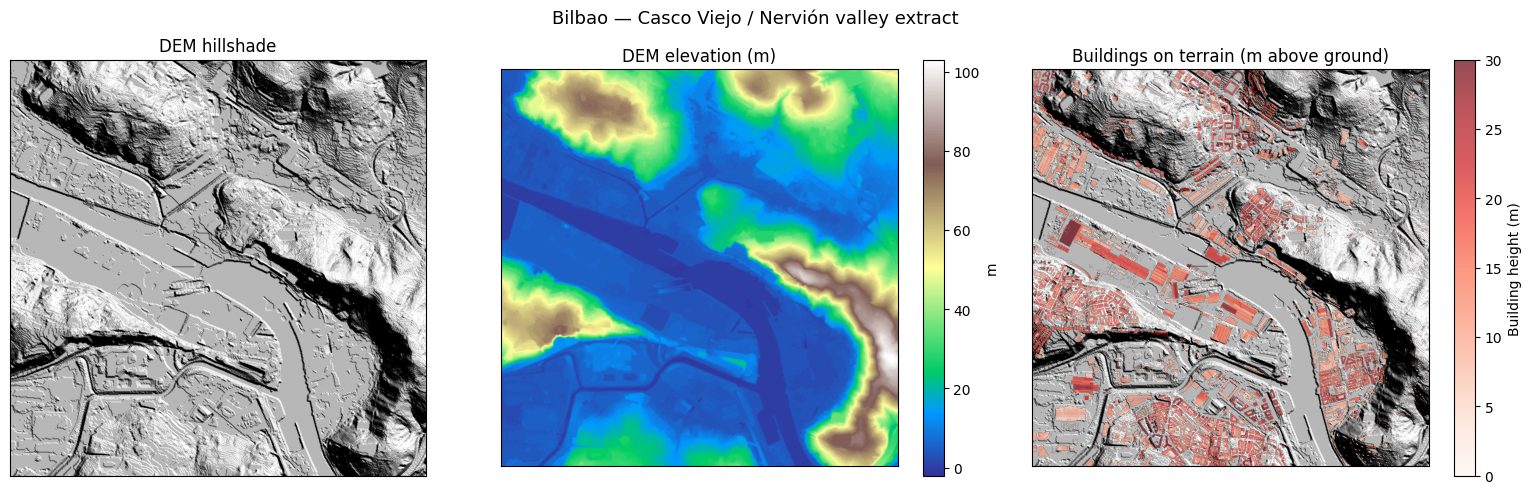

In [10]:
dem, dem_transform, dem_crs, _ = solweig.io.load_raster(str(DATA_DIR / "DEM.tif"))
bdsm, bdsm_transform, _, _ = solweig.io.load_raster(str(DATA_DIR / "BDSM.tif"))

print(f"DEM  shape: {dem.shape}  range: {np.nanmin(dem):.0f} – {np.nanmax(dem):.0f} m")
print(f"BDSM shape: {bdsm.shape}  building heights: 0 – {np.nanmax(bdsm):.0f} m above ground")

# Simple hillshade from DEM gradients
sun_az, sun_el = np.radians(225), np.radians(45)
dy, dx = np.gradient(dem)
slope = np.arctan(np.sqrt(dx**2 + dy**2))
aspect = np.arctan2(-dy, dx)
hillshade = np.clip(
    np.sin(sun_el) * np.cos(slope) + np.cos(sun_el) * np.sin(slope) * np.cos(sun_az - aspect),
    0,
    1,
)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

im0 = axes[0].imshow(hillshade, cmap="gray")
axes[0].set_title("DEM hillshade")

im1 = axes[1].imshow(dem, cmap="terrain")
axes[1].set_title("DEM elevation (m)")
plt.colorbar(im1, ax=axes[1], label="m")

# Resample BDSM to DEM grid for overlay (nearest-neighbour)
bdsm_ds = bdsm[::2, ::2]  # BDSM is 2× the DEM resolution
h, w = dem.shape
bdsm_ds = bdsm_ds[:h, :w]
building_mask = np.where(bdsm_ds > 0.5, bdsm_ds, np.nan)
axes[2].imshow(hillshade, cmap="gray")
im2 = axes[2].imshow(building_mask, cmap="Reds", alpha=0.7, vmin=0, vmax=30)
axes[2].set_title("Buildings on terrain (m above ground)")
plt.colorbar(im2, ax=axes[2], label="Building height (m)")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Bilbao — Casco Viejo / Nervión valley extract", fontsize=13)
plt.tight_layout()
plt.show()

## 2. Valley cross-section

A north–south profile through the centre of the domain reveals the classic bowl shape:
the Nervión river at the bottom, hillsides rising steeply on both sides.


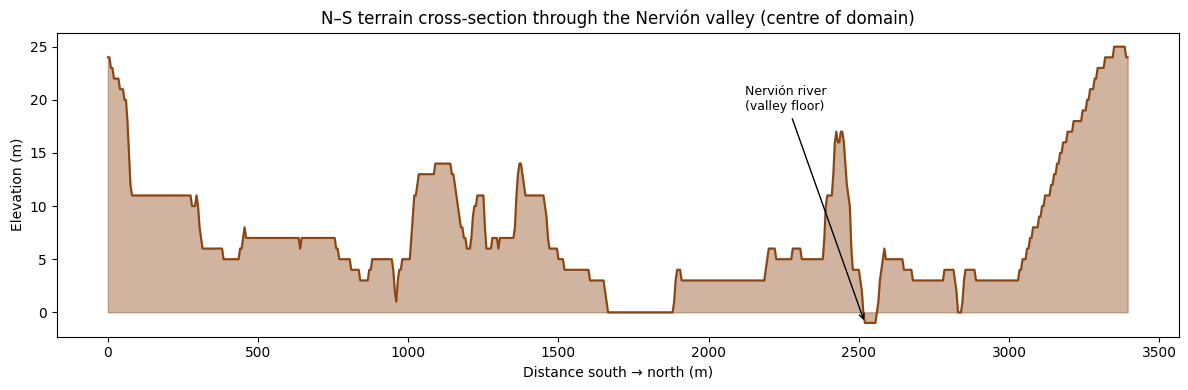

Relief across domain: 26 m over 3.4 km


In [11]:
mid_col = dem.shape[1] // 2
profile = dem[:, mid_col]
pixel_size_dem = 5.0  # DEM at ~5 m resolution
distance_m = np.arange(len(profile)) * pixel_size_dem

fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(distance_m, profile, alpha=0.4, color="saddlebrown", label="Terrain")
ax.plot(distance_m, profile, color="saddlebrown", linewidth=1.5)
ax.set_xlabel("Distance south → north (m)")
ax.set_ylabel("Elevation (m)")
ax.set_title("N–S terrain cross-section through the Nervión valley (centre of domain)")
ax.annotate(
    "Nervión river\n(valley floor)",
    xy=(distance_m[np.argmin(profile)], profile.min()),
    xytext=(distance_m[np.argmin(profile)] - 400, profile.min() + 20),
    arrowprops=dict(arrowstyle="->"),
    fontsize=9,
)
plt.tight_layout()
plt.show()

print(f"Relief across domain: {profile.max() - profile.min():.0f} m over {distance_m[-1] / 1000:.1f} km")

## 3. Generate a land cover map

SOLWEIG uses land cover classes to assign surface properties (albedo, emissivity,
thermal behaviour) that vary between asphalt, grass, water, etc. Without a land
cover map everything defaults to paved/cobblestone — the Nervión river would have
the same thermal properties as a car park.

We can derive a reasonable classification from the layers we already have:

| Source                                            | Class                 | UMEP ID |
| ------------------------------------------------- | --------------------- | ------- |
| BDSM > 0.5 m                                      | Buildings             | 2       |
| CDSM > 0.5 m (non-building)                       | Vegetation / grass    | 5       |
| DEM: low-elevation flat areas in the valley floor | Water (Nervión)       | 7       |
| Everything else                                   | Paved / urban surface | 0       |


In [ ]:
# Load CDSM (vegetation canopy heights)
cdsm, cdsm_transform, _, _ = solweig.io.load_raster(str(DATA_DIR / "CDSM.tif"))

# Start with paved (ID 0) everywhere
lc = np.zeros(dem.shape, dtype=np.uint8)

# Buildings (ID 2): where BDSM has height > 0.5 m
# Resample to DEM grid (BDSM is 2× DEM resolution)
bdsm_ds = bdsm[::2, ::2][: dem.shape[0], : dem.shape[1]]
lc[bdsm_ds > 0.5] = 2

# Vegetation (ID 5): where CDSM has canopy > 0.5 m and no building
cdsm_ds = cdsm[::2, ::2][: dem.shape[0], : dem.shape[1]]
veg_mask = (cdsm_ds > 0.5) & (lc != 2)
lc[veg_mask] = 5

# Water (ID 7): Nervión river — low elevation, flat terrain in the valley floor
dy, dx = np.gradient(dem)
slope_deg = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
water_mask = (dem < 1) & (slope_deg < 2) & (lc == 0)  # low, flat, not already classified
lc[water_mask] = 7

# Save as GeoTIFF (same grid as DEM)
lc_path = str(WORK_DIR / "land_cover.tif")
solweig.io.save_raster(lc_path, lc.astype(np.float32), dem_transform, dem_crs, no_data_val=255, generate_preview=False)

# Summary
unique, counts = np.unique(lc, return_counts=True)
lc_names = {0: "Paved", 2: "Buildings", 5: "Vegetation", 7: "Water"}
print("Land cover classification:")
for val, cnt in zip(unique, counts, strict=True):
    pct = 100 * cnt / lc.size
    print(f"  {lc_names.get(val, f'ID {val}'):12s} (ID {val}): {cnt:>8,} px  ({pct:.1f}%)")

# Visualise
lc_cmap = plt.matplotlib.colors.ListedColormap(["gray", "firebrick", "green", "steelblue"])
bounds = [-0.5, 1, 2.5, 6, 8]
norm = plt.matplotlib.colors.BoundaryNorm(bounds, lc_cmap.N)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(lc, cmap=lc_cmap, norm=norm, interpolation="nearest")
cbar = plt.colorbar(im, ax=ax, ticks=[0, 2, 5, 7], shrink=0.7)
cbar.ax.set_yticklabels(["Paved", "Buildings", "Vegetation", "Water"])
ax.set_title("Derived land cover classification")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

## 4. Prepare the surface

The key difference from the Athens workflow: the BDSM contains _relative_ building
heights (metres above ground, not above sea level). Setting `dsm_relative=True` tells
`prepare()` to compute the absolute DSM as `DEM + BDSM` before processing.

The land cover map generated above is passed in so that water and vegetation receive
appropriate surface properties instead of defaulting to paved/cobblestone everywhere.


In [13]:
surface = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "BDSM.tif"),
    dem=str(DATA_DIR / "DEM.tif"),
    cdsm=str(DATA_DIR / "CDSM.tif"),
    land_cover=lc_path,
    working_dir=str(WORK_DIR / "working"),
    bbox=EXTENTS_BBOX,
    pixel_size=2.5,
    dsm_relative=True,  # BDSM is height above ground — DEM provides the baseline
)

print(f"Surface shape: {surface.dsm.shape}")
print(f"Pixel size:    {surface.pixel_size} m")
print(f"Absolute DSM:  {np.nanmin(surface.dsm):.0f} – {np.nanmax(surface.dsm):.0f} m (terrain + buildings)")
print(f"Land cover:    {'yes' if surface.land_cover is not None else 'no'}")

INFO:solweig.models.surface:Preparing surface data from GeoTIFF files...
INFO:solweig.models.surface:  DSM: 1359×1359 pixels
INFO:solweig.models.surface:  Using specified pixel size: 2.50 m
INFO:solweig.models.surface:  CRS validated: ETRS89 / UTM zone 30N (EPSG:25830)
INFO:solweig.models.surface:  ✓ Canopy DSM (CDSM) provided
INFO:solweig.models.surface:  ✓ Ground elevation (DEM) provided
INFO:solweig.models.surface:  → No TDSM provided - will auto-generate from CDSM (ratio=0.25)
INFO:solweig.io:No-data value is 255.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Land cover provided (albedo/emissivity derived from classification)
INFO:solweig.models.surface:Checking for preprocessing data...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Walls found in working_dir: temp/tutorial_cache/bilbao/working/walls/px2.500
INFO:solweig.models.surface:  ✓ SVF loaded from memmap (memor

Surface shape: (1200, 1200)
Pixel size:    2.5 m
Absolute DSM:  -2 – 102 m (terrain + buildings)
Land cover:    yes


## 5. Load weather

We use a single clear summer morning (08:00 on July 2nd) — when the sun is still low
in the east and terrain shadows across the valley are at their most dramatic.


In [14]:
epw_path = str(DATA_DIR / "bilbao_2021.epw")
weather_list = solweig.Weather.from_epw(epw_path, start="2021-07-02", end="2021-07-02")
location = solweig.Location.from_epw(epw_path)

print(f"Location: {location.latitude:.2f}°N, {location.longitude:.2f}°E")

# Pick 08:00 (low morning sun) and 13:00 (high sun near solar noon)
w_08h = next(w for w in weather_list if w.datetime.hour == 8)
w_13h = next(w for w in weather_list if w.datetime.hour == 13)

for w in [w_08h, w_13h]:
    print(f"  {w.datetime:%H:%M}  Ta={w.ta:.1f}°C  RH={w.rh:.0f}%  GlobRad={w.global_rad:.0f} W/m²")

INFO:solweig.io:Loaded EPW file: unknown, 8760 timesteps (pure Python parser)
INFO:solweig.models.weather:Loaded 24 timesteps from EPW: 2021-07-02 00:00 → 2021-07-02 23:00
INFO:solweig.models.weather:Location from EPW: unknown — 43.2926°N, -2.9728°E (UTC+1, -3m)


Location: 43.29°N, -2.97°E
  08:00  Ta=17.1°C  RH=87%  GlobRad=367 W/m²
  13:00  Ta=23.0°C  RH=69%  GlobRad=918 W/m²


## 6. Terrain shadow contribution: flat vs terrain surface

To isolate terrain shadows properly, we run the same timestep twice:

- **Flat surface** — BDSM treated as absolute building heights on flat ground (no DEM). Only buildings cast shadow.
- **Terrain surface** — full surface with DEM + BDSM. Buildings _and_ hillsides cast shadow.

The difference between the two shadow maps is the pure terrain contribution — unconfounded by building shadow length or sun angle.


In [15]:
import tempfile

# Flat baseline: buildings on flat ground, no terrain
surface_flat = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "BDSM.tif"),
    working_dir=str(WORK_DIR / "working_flat"),
    bbox=EXTENTS_BBOX,
    pixel_size=2.5,
    # No DEM, no dsm_relative — BDSM values treated as absolute heights on flat ground
)

# Flat baseline: buildings on flat ground, no terrain
surface_terrain = solweig.SurfaceData.prepare(
    dsm=str(DATA_DIR / "BDSM.tif"),
    working_dir=str(WORK_DIR / "working_terrain"),
    bbox=EXTENTS_BBOX,
    pixel_size=2.5,
    dem=str(DATA_DIR / "DEM.tif"),
    dsm_relative=True,
)


def compute_shadow(sfc, weather_step, label):
    """Run a single-timestep shadow calculation and return the shadow grid."""
    with tempfile.TemporaryDirectory(prefix="solweig-bilbao-") as tmpdir:
        solweig.calculate(
            surface=sfc,
            weather=[weather_step],
            location=location,
            output_dir=tmpdir,
            outputs=["shadow"],
            max_shadow_distance_m=1000,
        )
        shadow_files = list(Path(tmpdir).glob("shadow/*.tif"))
        shadow, *_ = solweig.io.load_raster(str(shadow_files[0]))
    print(f"  {label}: shaded fraction = {(shadow < 0.5).mean():.1%}")
    return shadow


print("08:00 (low morning sun):")
shadow_08_flat = compute_shadow(surface_flat, w_08h, "flat (buildings only)")
shadow_08_terrain = compute_shadow(surface_terrain, w_08h, "terrain + buildings")

print("\n13:00 (near solar noon):")
shadow_13_flat = compute_shadow(surface_flat, w_13h, "flat (buildings only)")
shadow_13_terrain = compute_shadow(surface_terrain, w_13h, "terrain + buildings")

INFO:solweig.models.surface:Preparing surface data from GeoTIFF files...


INFO:solweig.models.surface:  DSM: 1359×1359 pixels
INFO:solweig.models.surface:  Using specified pixel size: 2.50 m
INFO:solweig.models.surface:  CRS validated: ETRS89 / UTM zone 30N (EPSG:25830)
INFO:solweig.models.surface:  → No vegetation data - simulation without trees/vegetation
INFO:solweig.models.surface:Checking for preprocessing data...
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.io:No-data value is -9999.0, replacing with NaN
INFO:solweig.models.surface:  ✓ Walls found in working_dir: temp/tutorial_cache/bilbao/working_flat/walls/px2.500
INFO:solweig.models.surface:  ✓ SVF loaded from memmap (memory-efficient)
INFO:solweig.models.surface:  ✓ SVF found in working_dir: temp/tutorial_cache/bilbao/working_flat/svf/px2.500
INFO:solweig.models.surface:  ✓ Shadow matrices loaded from npz
INFO:solweig.models.surface:  ✓ Shadow matrices found (anisotropic sky enabled)
INFO:solweig.models.surface:Computing spatial extent and resolution...
INFO:solweig.mod

08:00 (low morning sun):


INFO:solweig.timeseries:  Pre-computed 1 timesteps in 0.1s
SOLWEIG timeseries: 100%|██████████| 1/1 [00:22<00:00, 22.84s/it]
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:✓ Calculation complete: 1 timesteps processed
INFO:solweig.timeseries:  Total time: 23.4s (0.04 steps/s)
INFO:solweig.timeseries:  Tmrt range: 14.4°C - 46.3°C (mean: 27.9°C)
INFO:solweig.timeseries:  Files saved: 1 GeoTIFFs in /var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/solweig-bilbao-qen0wp47
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 1200×1200 pixels
INFO:solweig.timeseries:  Timesteps: 1
INFO:solweig.timeseries:  Period: 2021-07-02 08:00 → 2021-07-02 08:00
INFO:solweig.timeseries:  Location: 43.29°N, -2.97°E
INFO:solweig.tim

  flat (buildings only): shaded fraction = 57.4%


SOLWEIG timeseries: 100%|██████████| 1/1 [00:13<00:00, 13.17s/it]
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:✓ Calculation complete: 1 timesteps processed
INFO:solweig.timeseries:  Total time: 13.6s (0.07 steps/s)
INFO:solweig.timeseries:  Tmrt range: 14.4°C - 46.3°C (mean: 22.9°C)
INFO:solweig.timeseries:  Files saved: 1 GeoTIFFs in /var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/solweig-bilbao-zlahe9u4
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 1200×1200 pixels
INFO:solweig.timeseries:  Timesteps: 1
INFO:solweig.timeseries:  Period: 2021-07-02 13:00 → 2021-07-02 13:00
INFO:solweig.timeseries:  Location: 43.29°N, -2.97°E
INFO:solweig.timeseries:  Options: anisotropic sky
INFO:solweig.timeseries:

  terrain + buildings: shaded fraction = 77.8%

13:00 (near solar noon):


INFO:solweig.timeseries:  Pre-computed 1 timesteps in 0.1s
SOLWEIG timeseries: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:✓ Calculation complete: 1 timesteps processed
INFO:solweig.timeseries:  Total time: 9.7s (0.10 steps/s)
INFO:solweig.timeseries:  Tmrt range: 20.9°C - 56.4°C (mean: 47.5°C)
INFO:solweig.timeseries:  Files saved: 1 GeoTIFFs in /var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/solweig-bilbao-vrslytg9
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 1200×1200 pixels
INFO:solweig.timeseries:  Timesteps: 1
INFO:solweig.timeseries:  Period: 2021-07-02 13:00 → 2021-07-02 13:00
INFO:solweig.timeseries:  Location: 43.29°N, -2.97°E
INFO:solweig.time

  flat (buildings only): shaded fraction = 17.5%


SOLWEIG timeseries: 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:✓ Calculation complete: 1 timesteps processed
INFO:solweig.timeseries:  Total time: 7.0s (0.14 steps/s)
INFO:solweig.timeseries:  Tmrt range: 20.9°C - 56.4°C (mean: 47.7°C)
INFO:solweig.timeseries:  Files saved: 1 GeoTIFFs in /var/folders/9_/5x31j5x55819zxycf85n4cp40000gq/T/solweig-bilbao-vz3a1eqq
INFO:solweig.timeseries:============================================================


  terrain + buildings: shaded fraction = 19.8%


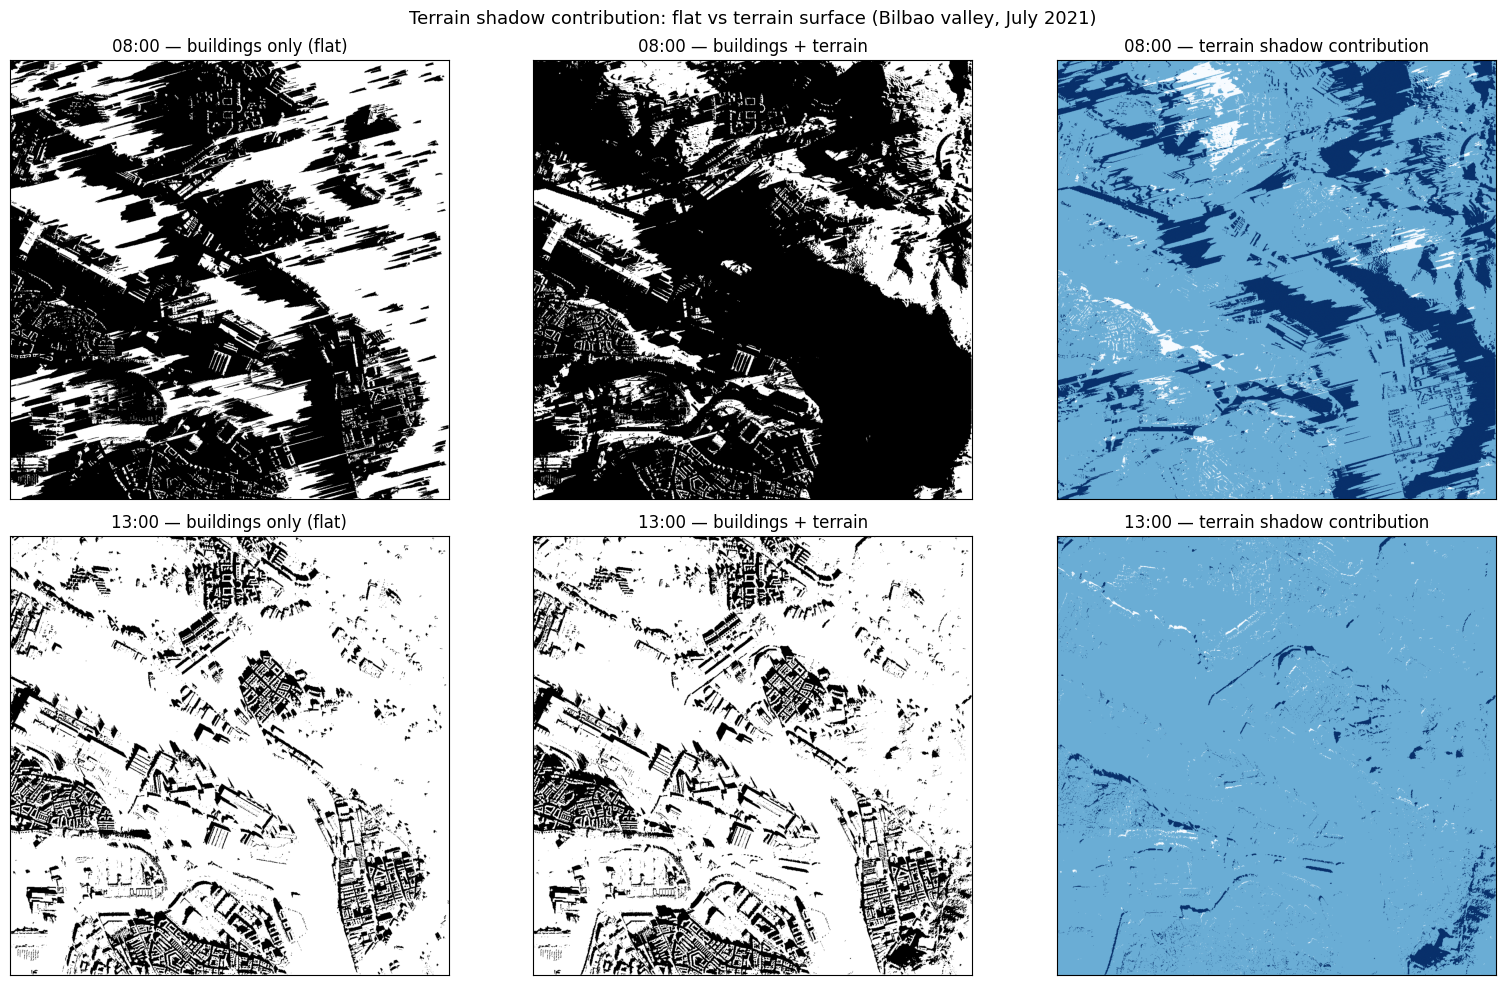

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

kw = dict(cmap="gray", vmin=0, vmax=1)

axes[0, 0].imshow(shadow_08_flat, **kw)
axes[0, 0].set_title("08:00 — buildings only (flat)")

axes[0, 1].imshow(shadow_08_terrain, **kw)
axes[0, 1].set_title("08:00 — buildings + terrain")

terrain_shadow_08 = 1 - (shadow_08_terrain - shadow_08_flat)
axes[0, 2].imshow(terrain_shadow_08, cmap="Blues")
axes[0, 2].set_title("08:00 — terrain shadow contribution")

axes[1, 0].imshow(shadow_13_flat, **kw)
axes[1, 0].set_title("13:00 — buildings only (flat)")

axes[1, 1].imshow(shadow_13_terrain, **kw)
axes[1, 1].set_title("13:00 — buildings + terrain")

terrain_shadow_13 = 1 - (shadow_13_terrain - shadow_13_flat)
axes[1, 2].imshow(terrain_shadow_13, cmap="Blues")
axes[1, 2].set_title("13:00 — terrain shadow contribution")

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(
    "Terrain shadow contribution: flat vs terrain surface (Bilbao valley, July 2021)",
    fontsize=13,
)
plt.tight_layout()
plt.show()

## 7. Multi-day summary: valley sun exposure

Running a 3-day timeseries (including nighttime hours) lets us build up the
accumulated sun-hour map and compare daytime vs overall thermal conditions —
the most revealing outputs for understanding how valley geometry drives
long-term thermal comfort across the area.


In [20]:
all_weather = solweig.Weather.from_epw(epw_path, start="2021-07-01", end="2021-07-03")
print(f"Timesteps: {len(all_weather)} ({len(all_weather) // 3} per day × 3 days)")

OUTPUT_DIR = WORK_DIR / "output_valley"

summary = solweig.calculate(
    surface=surface,
    weather=all_weather,
    location=location,
    output_dir=str(OUTPUT_DIR),
    outputs=["tmrt", "shadow"],
    max_shadow_distance_m=500,
)
print(summary.report())

INFO:solweig.io:Loaded EPW file: unknown, 8760 timesteps (pure Python parser)
INFO:solweig.models.weather:Loaded 72 timesteps from EPW: 2021-07-01 00:00 → 2021-07-03 23:00
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Starting SOLWEIG timeseries calculation
INFO:solweig.timeseries:  Grid size: 1200×1200 pixels
INFO:solweig.timeseries:  Timesteps: 72
INFO:solweig.timeseries:  Period: 2021-07-01 00:00 → 2021-07-03 23:00
INFO:solweig.timeseries:  Location: 43.29°N, -2.97°E
INFO:solweig.timeseries:  Options: anisotropic sky
INFO:solweig.timeseries:  Auto-save: temp/tutorial_cache/bilbao/output_valley (tmrt, shadow)
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:Pre-computing sun positions and radiation splits...


Timesteps: 72 (24 per day × 3 days)


INFO:solweig.timeseries:  Pre-computed 72 timesteps in 0.4s
SOLWEIG timeseries:   0%|          | 0/72 [00:00<?, ?it/s]/Users/gareth/dev/umep/solweig/pysrc/solweig/physics/clearnessindex_2013b.py:29: RuntimeWarning: invalid value encountered in scalar power
  1.021 - 0.084 * (m * (0.000949 * p + 0.051)) ** 0.5
/Users/gareth/dev/umep/solweig/pysrc/solweig/physics/clearnessindex_2013b.py:67: RuntimeWarning: invalid value encountered in scalar power
  Tw = 1 - 0.077 * ((u * m) ** 0.3)  # Transmission coefficient for water vapor
SOLWEIG timeseries: 100%|██████████| 72/72 [10:34<00:00,  8.81s/it]
INFO:solweig.timeseries:============================================================
INFO:solweig.timeseries:✓ Calculation complete: 72 timesteps processed
INFO:solweig.timeseries:  Total time: 635.0s (0.11 steps/s)
INFO:solweig.timeseries:  Tmrt range: 8.3°C - 64.9°C (mean: 22.3°C)
INFO:solweig.timeseries:  Files saved: 144 GeoTIFFs in temp/tutorial_cache/bilbao/output_valley
INFO:solweig.timeserie

SOLWEIG Summary: 72 timesteps (45 day, 27 night)
  Period: 2021-07-01 00:00 — 2021-07-03 23:00
  Tmrt  — mean: 22.3°C, range: 8.3 – 64.9°C
  UTCI  — mean: 19.6°C, range: 13.6 – 34.3°C
  Sun   — 0.0 – 72.0 hours
  UTCI > 32°C (day) — max 4.0h
  Ta    — range: 13.3 – 23.0°C
  Summary GeoTIFFs: temp/tutorial_cache/bilbao/output_valley/summary/
    shade_hours.tif
    sun_hours.tif
    tmrt_day_mean.tif
    tmrt_max.tif
    tmrt_mean.tif
    tmrt_min.tif
    tmrt_night_mean.tif
    utci_day_mean.tif
    utci_hours_above_26_night.tif
    utci_hours_above_32_day.tif
    utci_hours_above_38_day.tif
    utci_max.tif
    utci_mean.tif
    utci_min.tif
    utci_night_mean.tif

Tip: per-timestep arrays are in summary.timeseries (e.g. .ta, .tmrt_mean, .utci_mean).
     Spatial grids are on the summary itself (e.g. .tmrt_mean, .utci_max).
     Summary grids are saved as GeoTIFFs above; timeseries arrays are in memory only.


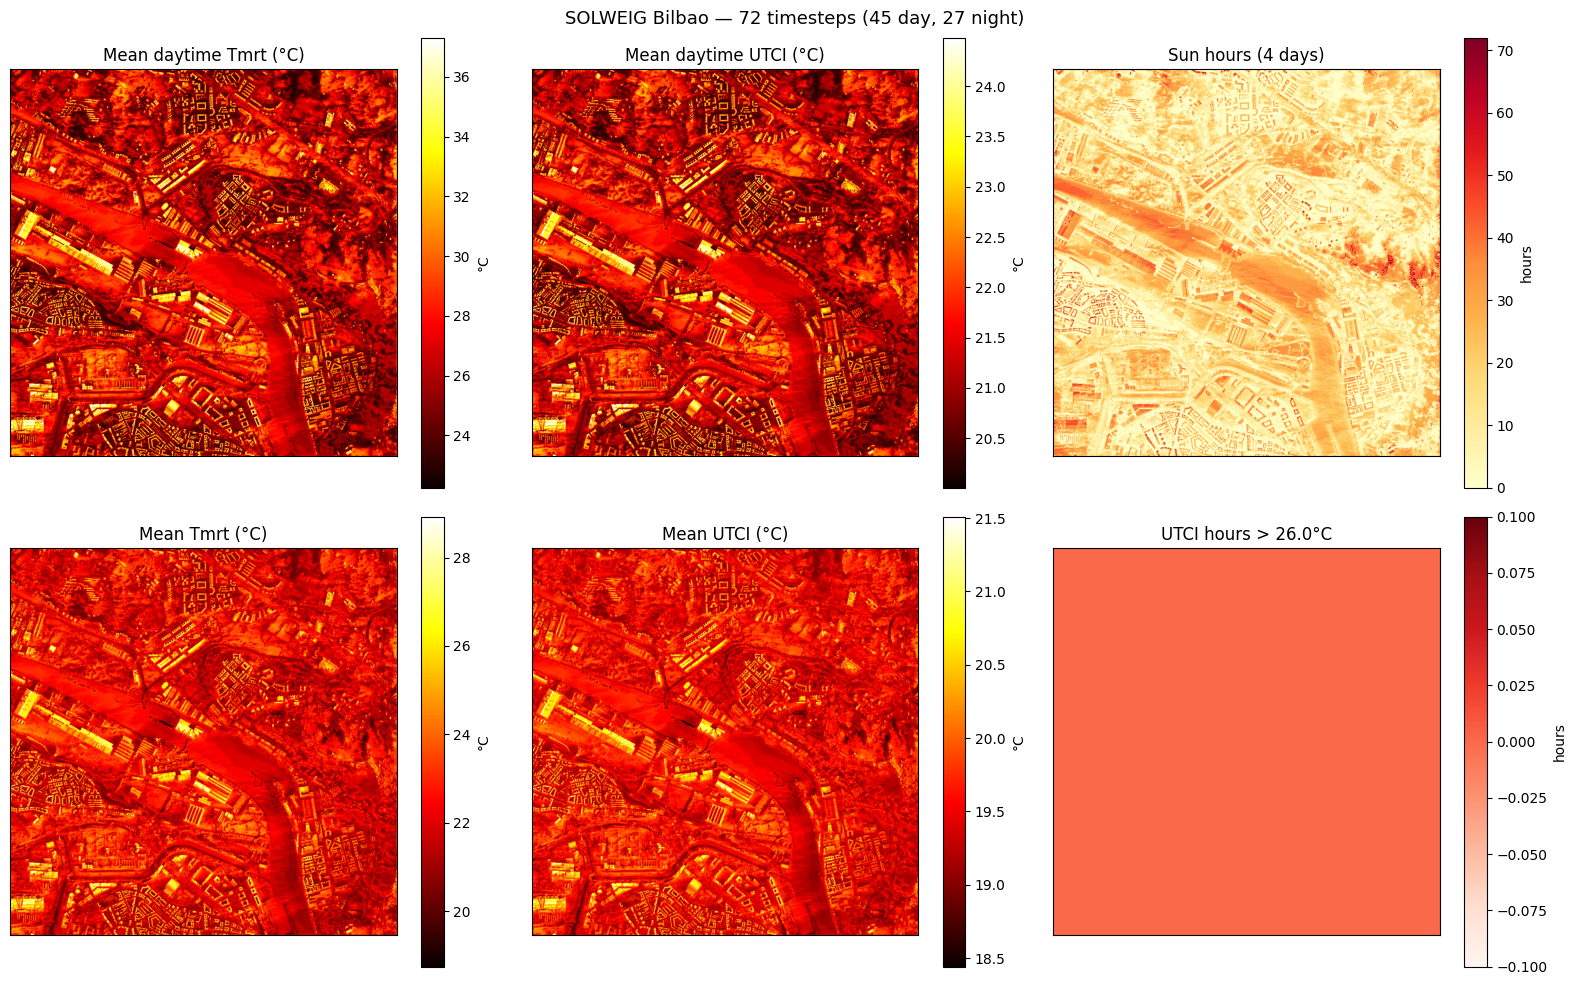

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

im0 = axes[0, 0].imshow(summary.tmrt_day_mean, cmap="hot")
axes[0, 0].set_title("Mean daytime Tmrt (°C)")
plt.colorbar(im0, ax=axes[0, 0], label="°C")

im1 = axes[0, 1].imshow(summary.utci_day_mean, cmap="hot")
axes[0, 1].set_title("Mean daytime UTCI (°C)")
plt.colorbar(im1, ax=axes[0, 1], label="°C")

im2 = axes[0, 2].imshow(summary.sun_hours, cmap="YlOrRd")
axes[0, 2].set_title("Sun hours (4 days)")
plt.colorbar(im2, ax=axes[0, 2], label="hours")

im3 = axes[1, 0].imshow(summary.tmrt_mean, cmap="hot")
axes[1, 0].set_title("Mean Tmrt (°C)")
plt.colorbar(im3, ax=axes[1, 0], label="°C")

im4 = axes[1, 1].imshow(summary.utci_mean, cmap="hot")
axes[1, 1].set_title("Mean UTCI (°C)")
plt.colorbar(im4, ax=axes[1, 1], label="°C")

threshold = sorted(summary.utci_hours_above.keys())[0]
im5 = axes[1, 2].imshow(summary.utci_hours_above[threshold], cmap="Reds")
axes[1, 2].set_title(f"UTCI hours > {threshold}°C")
plt.colorbar(im5, ax=axes[1, 2], label="hours")

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle(
    f"SOLWEIG Bilbao — {len(summary)} timesteps ({summary.n_daytime} day, {summary.n_nighttime} night)",
    fontsize=13,
)
plt.tight_layout()
plt.show()